# MNIST DATASET
In this section, the goal will be to test the performance of the three implementation methods for the Hopfield model seen so far on a real dataset, MNIST, which contains handwritten digits.

The MNIST dataset consists in a 28x28 pixel grayscale images of handwritten digits (0–9) along with their corresponding labels.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
# Load the dataset
df_train = pd.read_csv("data/mnist_train.csv")
df_test = pd.read_csv("data/mnist_test.csv")

# Check the shapes
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (60000, 785)
Test shape: (10000, 785)


The dataset is composed of 785 columns. From 1 to 784 represents each pixel of the image (28x28), while the last one (785) is the label containing the value of the corresponding digit.

Now I have to separate data in features and labels matrices and then normalize them.

In [3]:
# Divide features and labels
y_train = df_train["label"].values
x_train = df_train.drop("label", axis=1).values

y_test = df_test["label"].values
x_test = df_test.drop("label", axis=1).values

#### Data preprocessing

In [4]:
def binarize_image(image, threshold=0.35):
    """
    Put all the values to -1 or +1 according to the spin

    images: data to be binarized
    threshold: 127 because the greyscale is from 0 to 255
    """
    img = deepcopy(image)
    img = img/255
    return np.where(img > threshold, -1, 1)

def select_average_images(images, labels):

    averaged_images = []
    averaged_labels = []
    
    for _ in range(1):
        for digit in range(10):
            indices = np.where(labels == digit)[0]  # Trova gli indici delle immagini con quella cifra
            digit_images = images[indices]
            averaged_image = np.mean(digit_images, axis=0)  # Calcola la media delle immagini per quella cifra
            averaged_images.append(averaged_image)
            averaged_labels.append(digit)

    return np.vstack(averaged_images), np.array(averaged_labels)

import numpy as np

def select_images(images, labels):
    """
    Select a random digit for each digit (0-9) from the input
    
    images: array of images (shape: [N, 28, 28] or [N, 784])
    labels: array corresponding labels (shape: [N])

    Return:
        selected_images: array with 10 images (one for each digit)
        selected_labels: array with correspondent labels (0-9)
    """
    selected_images, selected_labels = [], []

    for digit in range(10):
        indices = np.where(labels == digit)[0]  

        if len(indices) > 0: 
            chosen_index = np.random.choice(indices, 1)  
            selected_images.append(images[chosen_index].reshape(1, -1))  
            selected_labels.append(digit)

    return np.vstack(selected_images), np.array(selected_labels)

def crop_dataset(dataset, border_width=4, image_shape=(28, 28), flatten=True):
    """
    Rimuove una cornice di 'border_width' pixel da ogni lato delle immagini nel dataset.
    
    Parametri:
      - dataset (np.array): array di immagini in forma appiattita con shape (N, n_features) 
                            (per MNIST n_features=28*28=784).
      - border_width (int): numero di pixel da rimuovere da ciascun lato.
      - image_shape (tuple): dimensioni originali dell'immagine (es. (28, 28)).
      - flatten (bool): se True restituisce le immagini appiattite, altrimenti come 2D.
    
    Ritorna:
      - np.array: dataset con le immagini ritagliate. Se flatten è True, shape = (N, new_features),
                  dove new_features = (image_shape[0] - 2*border_width) * (image_shape[1] - 2*border_width);
                  altrimenti, shape = (N, new_h, new_w).
    """
    N = dataset.shape[0]
    # Rimodella il dataset in (N, h, w)
    h, w = image_shape
    images = dataset.reshape(N, h, w)
    
    # Ritaglia le immagini: seleziona le righe e colonne desiderate
    cropped_images = images[:, border_width:h-border_width, border_width:w-border_width]
    
    if flatten:
        # Appiattisce ciascuna immagine
        new_h, new_w = cropped_images.shape[1], cropped_images.shape[2]
        return cropped_images.reshape(N, new_h * new_w)
    else:
        return cropped_images

def predict_label(recovered, stored_patterns, stored_labels):
    """
    Confronta il pattern recuperato con ciascun pattern memorizzato utilizzando la distanza Hamming.
    Restituisce la label del pattern più simile.

    Parametri:
      - recovered: pattern recuperato (array 1D).
      - stored_patterns: array di pattern memorizzati (ogni riga corrisponde a un pattern).
      - stored_labels: array delle label corrispondenti a stored_patterns.
    """
    # Calcola la distanza assoluta (Hamming) per ciascun pattern
    distances = np.sum(np.abs(stored_patterns - recovered), axis=1)
    # Trova l'indice del pattern più vicino
    min_index = np.argmin(distances)
    
    return stored_labels[min_index]

In [5]:
# Fill the new matrices
# patterns, labels = select_images(x_train, y_train)
patterns, labels = select_average_images(x_train, y_train)
print(np.shape(patterns))
print(labels)

# Binarize data
patterns = binarize_image(patterns)
x_train = binarize_image(x_train)

# Crop dataset
patterns = crop_dataset(patterns, border_width=4)
print("New shape:", np.shape(patterns))

(10, 784)
[0 1 2 3 4 5 6 7 8 9]
New shape: (10, 400)


Helper functions

In [6]:
# Define the corruption function
def cut_image(image, side="left"):
    """
    Cut an image at half putting to zero one of the two parts.

    image: image to corrupt
    side: decide which side of the picture keep
        - "left": keep the left side of the image
        - "right": keep the right side of the image
    """
    cut = image.shape[0] // 2 
    corrupted_image = np.copy(image)
    
    if side == "left":
        corrupted_image[cut:] = -1  # Put to zero the right side of the image
    elif side == "right":
        corrupted_image[:cut] = -1  # Put to zero the left side of the image
    
    return corrupted_image

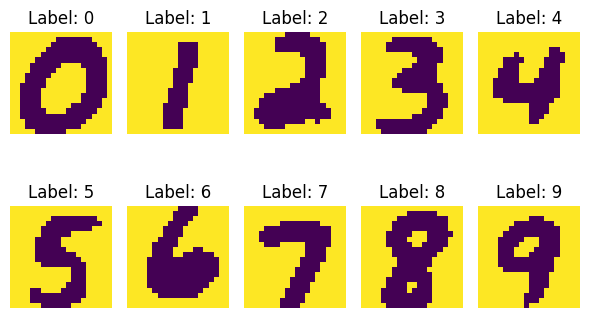

In [7]:
# Visualize images
fig, axs = plt.subplots(2, 5, figsize=(6, 4))
axs = axs.ravel()  

for p, l in zip(patterns, labels):
    
    axs[l].imshow(p.reshape(20, 20))
    axs[l].set_title(f"Label: {l}")
    axs[l].axis("off")

plt.tight_layout()
plt.show()

## Train the network with the three previous methods

### 1. Deterministic Hopfield

### 2. MonteCarlo

Import functions

In [8]:
def compute_weights_1d(patterns):
    N_spins = patterns.shape[1]
    weight_matrix = (1/N_spins) * np.outer(patterns[0], patterns[0])

    for i in range(1, patterns.shape[0]):
        weight_matrix += (1/N_spins) * np.outer(patterns[i], patterns[i])

    np.fill_diagonal(weight_matrix, 0)

    return weight_matrix

def compute_energy_1d(pattern, weights):
    E = -0.5 * np.dot(pattern, np.dot(weights, pattern))
    return E

def pattern_corruption_1d(pattern,q):
    corrupted = pattern.copy()
    flip_numbers = int(len(pattern) * q)
    flip_indexes = np.random.choice(len(pattern), flip_numbers, replace = False)
    corrupted[flip_indexes] *= -1
    return corrupted

def metropolis_1d(corrupted, weights, T, steps):
    beta = 1/T
    pattern_copy = corrupted.copy()
    
    for _ in range(steps):
        i = np.random.randint(0,len(corrupted))
        hi = np.sum(weights[i] * pattern_copy)
        Delta_E = 2 * pattern_copy[i] * hi
        x = np.random.random()
        
        #Metropolis condition:
        if Delta_E < 0 or x < np.exp(-beta * Delta_E):
            pattern_copy[i] *= -1
    return pattern_copy

def check_correctness(original, retrieved):
    return np.mean(original == retrieved)  # Fraction of correct spins

def mattis_overlap_1d(pattern, retrieved):
    return (1/len(pattern))*np.dot(pattern, retrieved)

[-288.9050000000004, -481.105, -486.8850000000003, -498.40500000000054, -566.8850000000002, -598.685, -482.12500000000057, -582.3850000000003, -602.8649999999998, -701.484999999999]


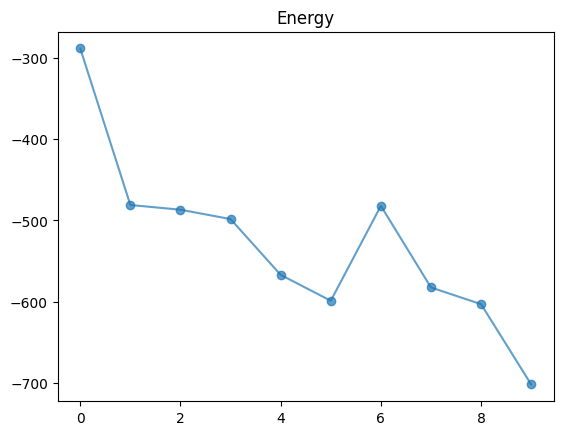

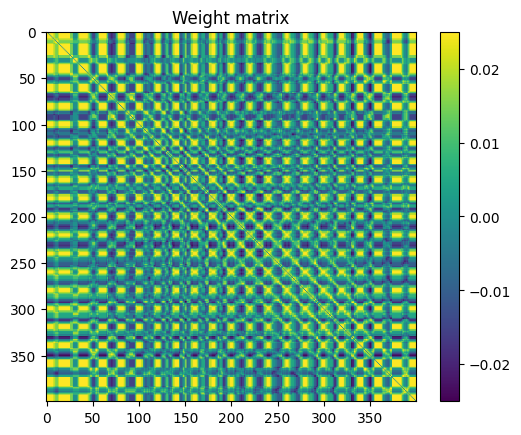

True label: 0, Predicted label: 5
Mattis overlap: 0.52
Accuracy: 0.76


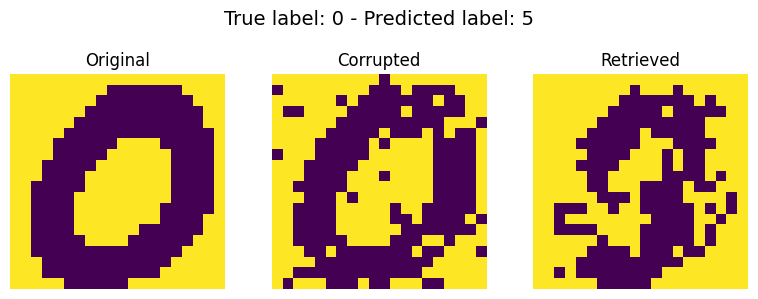

True label: 1, Predicted label: 9
Mattis overlap: 0.645
Accuracy: 0.8225


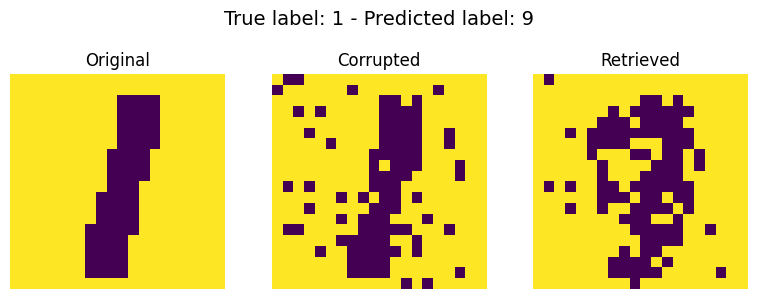

True label: 2, Predicted label: 2
Mattis overlap: 0.675
Accuracy: 0.8375


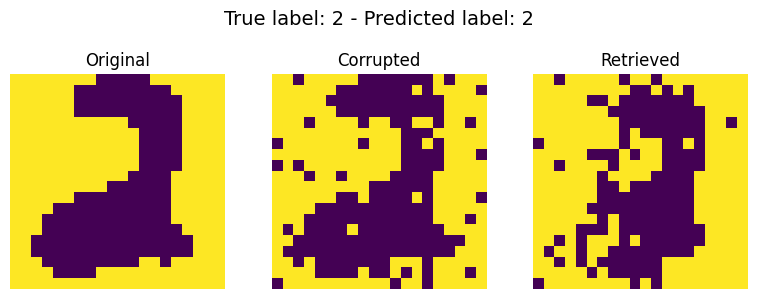

True label: 3, Predicted label: 5
Mattis overlap: 0.705
Accuracy: 0.8525


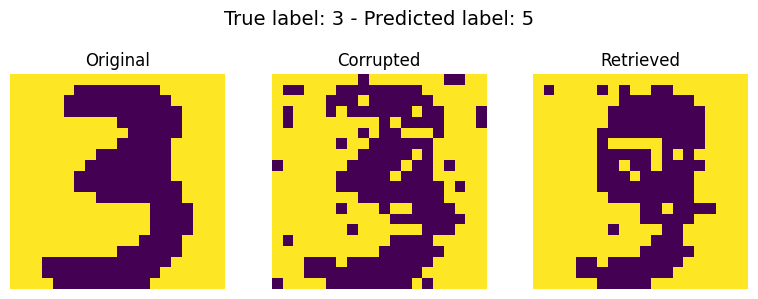

True label: 4, Predicted label: 9
Mattis overlap: 0.75
Accuracy: 0.875


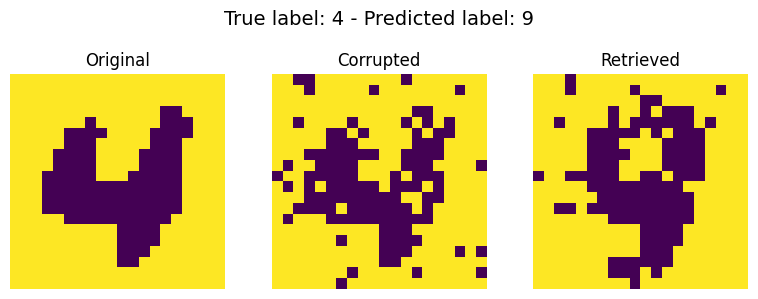

True label: 5, Predicted label: 5
Mattis overlap: 0.735
Accuracy: 0.8675


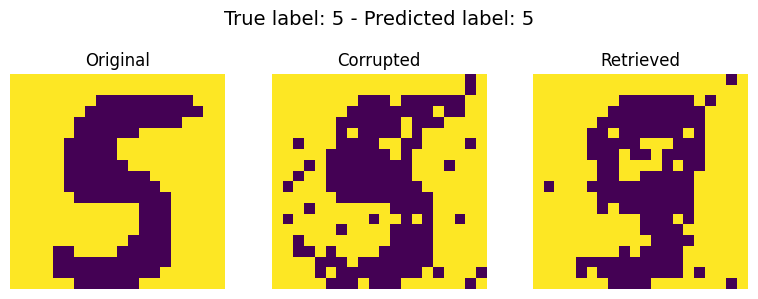

True label: 6, Predicted label: 9
Mattis overlap: 0.595
Accuracy: 0.7975


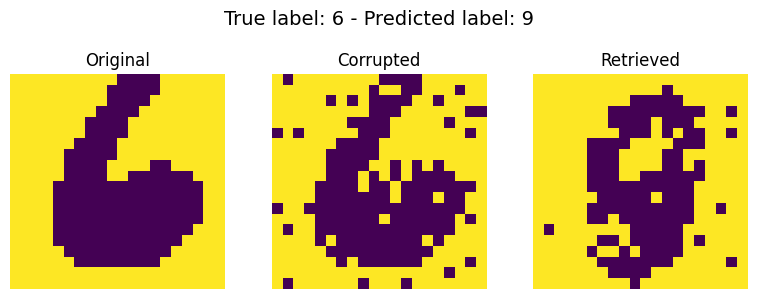

True label: 7, Predicted label: 7
Mattis overlap: 0.8250000000000001
Accuracy: 0.9125


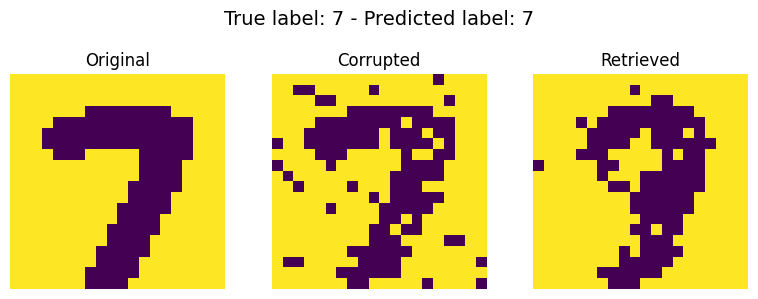

True label: 8, Predicted label: 9
Mattis overlap: 0.675
Accuracy: 0.8375


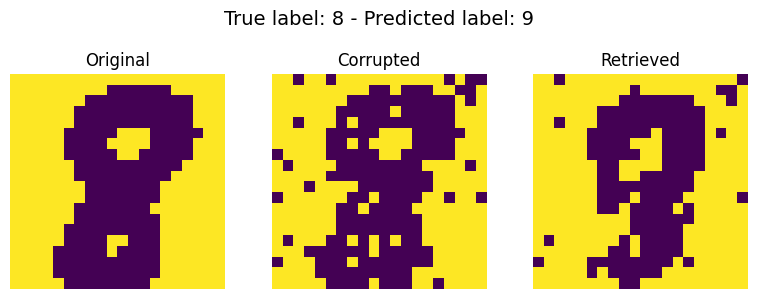

True label: 9, Predicted label: 9
Mattis overlap: 0.87
Accuracy: 0.935


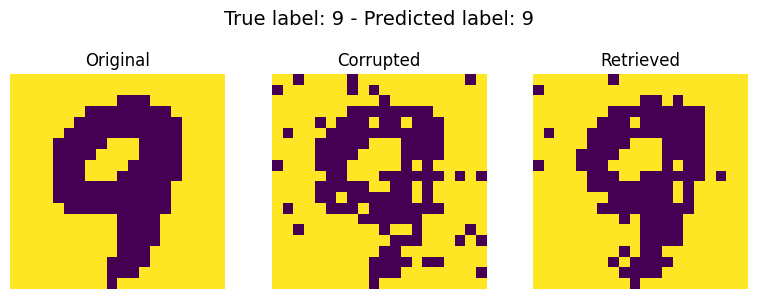

In [9]:
J = compute_weights_1d(patterns) # compute the weights matrix
energy = []
for p in patterns:
    energy.append(compute_energy_1d(p, J))

print(energy)
plt.plot(np.arange(0, 10, 1), energy, marker="o", alpha=0.7)
plt.title("Energy")
plt.show()

plt.imshow(J)
plt.colorbar()
plt.title("Weight matrix")
plt.show()

q = 0.1
T = 0.1 # thermal noise
steps = 500 # number of iterations

for p, true_label in zip(patterns, labels):
    # Usa direttamente il pattern corrente come original
    original = p  
    # Calcola o definisci J se non l'hai già fatto (qui supponiamo che J sia definito esternamente)
    # J = compute_weights_1d(original)
    
    # Crea il pattern corrotto (ad es. con una funzione di corruzione)
    corrupted = pattern_corruption_1d(original, q) 
    # Recupera il pattern con il metodo Metropolis
    retrieved_pattern = metropolis_1d(corrupted, J, T, steps)
    
    # Predici la label confrontando il pattern recuperato con i pattern memorizzati
    predicted_label = predict_label(retrieved_pattern, patterns, labels)
    
    # Stampa le informazioni desiderate
    print(f"True label: {true_label}, Predicted label: {predicted_label}")
    print("Mattis overlap:", mattis_overlap_1d(original, retrieved_pattern))
    print("Accuracy:", check_correctness(original, retrieved_pattern))
    
    # Visualizza i pattern: originale, corrotto e recuperato
    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    
    axs[0].imshow(original.reshape(20, 20))
    axs[0].set_title("Original")
    axs[0].axis("off")
    
    axs[1].imshow(corrupted.reshape(20, 20))
    axs[1].set_title("Corrupted")
    axs[1].axis("off")
    
    axs[2].imshow(retrieved_pattern.reshape(20, 20))
    axs[2].set_title("Retrieved")
    axs[2].axis("off")
    
    plt.suptitle(f"True label: {true_label} - Predicted label: {predicted_label}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

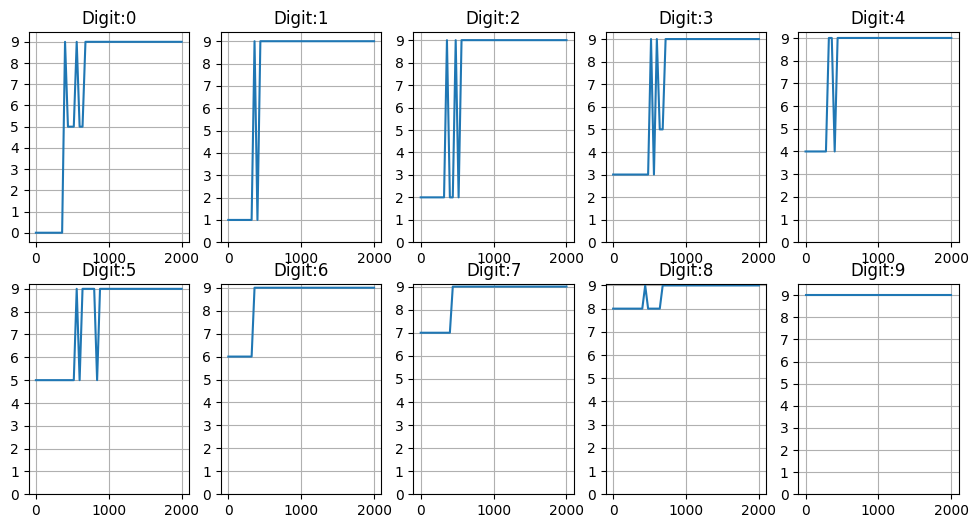

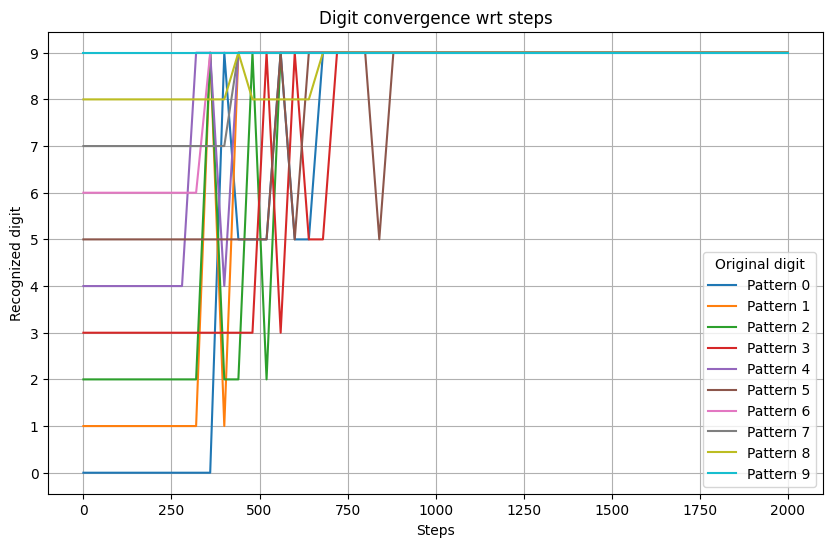

In [10]:
steps_max = 2000   
step_increment = 40 
steps_values = np.arange(0, steps_max+1, step_increment) 

J = compute_weights_1d(patterns)
T = 0.1

recognized_digits_all = []  
for idx, (p, original_digit) in enumerate(zip(patterns, labels)):
    recognized_steps = []  

    for s in steps_values:

        corrupted = pattern_corruption_1d(p, q)  
        retrieved = metropolis_1d(corrupted, J, T, int(s))
        
        overlaps = [mattis_overlap_1d(stored, retrieved) for stored in patterns]
        recognized_digit = np.argmax(overlaps)  # take the index with the max overlap
        recognized_steps.append(recognized_digit)
        
    recognized_digits_all.append(recognized_steps)

# Plot 
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, rec in enumerate(recognized_digits_all):
    row, col = divmod(i, 5)

    axs[row, col].plot(steps_values, rec, label=f"Pattern {labels[i]}")
    #axs[row, col].set_xlabel("Steps")
    #axs[row, col].set_ylabel("Recognized digit")
    axs[row, col].set_title(f"Digit:{i}")
    axs[row, col].set_yticks(np.arange(0, 10))
    axs[row, col].grid(True)
    #axs[row, col].legend(title="Original digit", loc="best")

plt.figure(figsize=(10, 6))
for i, rec in enumerate(recognized_digits_all):
    plt.plot(steps_values, rec, label=f"Pattern {labels[i]}")
plt.xlabel("Steps")
plt.ylabel("Recognized digit")
plt.title("Digit convergence wrt steps")
plt.yticks(np.arange(0, 10, 1))
plt.grid(True)
plt.legend(title="Original digit", loc="best")
plt.show()

### 3. Modern Hopfield

In [11]:
class modern_hopfield():
  
  def __init__(self, pattern_lenght: int, func_type: str = "Polyn", poly_order: int = 3):
    """
    `pattern_lenght`: number of neurons of the network \n
    `func_type`: type of function to evaluate the energy of a single pattern. 
    Possible options are "Polyn", "RePn", "Exp" \n
    `poly_order`: order of the polynomial function used in the evaluation of the energy
    """
    self.pattern_lenght = pattern_lenght
    self.memory_matrix = np.zeros(shape=(1,self.pattern_lenght))
    self.func_type = func_type
    self.n = poly_order
    return
  
  def add_patterns(self, p: np.ndarray):
    """
    `p`: pattern to add to memory
    """
    if self.memory_matrix[0,0]==0:
      self.memory_matrix = p
    else:
      self.memory_matrix = np.vstack((self.memory_matrix, p))
    return

  def retrieve_pattern(self, p: np.ndarray, epochs: int):
    """
    `p`: input pattern  \n
    `epochs`: maximum number of iterations \n
    performs the update rule up to `epochs` times, trying to match the input pattern `p` to a pattern stored in memory     
    """
    sigma = p.copy()
    for epoch in range(epochs):
      sigma = self._update_rule(sigma)
    return sigma

  def _update_rule(self, sigma: np.ndarray):
    """
    `sigma`: vector containing the values of the network's neurons at time t. \n 
    Returns the values of the network's neurons at time t+1 
    """
    s = 0
    for xi in self.memory_matrix:
      s += self._F(xi + np.dot(xi, sigma) - np.multiply(xi, sigma)) - self._F(-xi + np.dot(xi, sigma) - np.multiply(xi, sigma))
    return np.sign(s)

  def _F(self, x: np.ndarray):
    """
    Energy function used in the update rule. \n
    Different types of function:
    - `Polyn`: polynomial function of order n
    - `RePn`: rectified polynomial function of order n
    - `Exp`: exponential function
    """
    match self.func_type:
      case "Polyn":
        return x**self.n
      case "RePn":
        return np.maximum(0, x**self.n)
      case "Exp":
        return np.exp(x)
  
  def energy(self, sigma: np.ndarray):

    field = np.dot(self.memory_matrix, sigma) 
    return -np.sum(self._F(field))

Test if the algorithm works correctly

True label: 0, Predicted label: 0


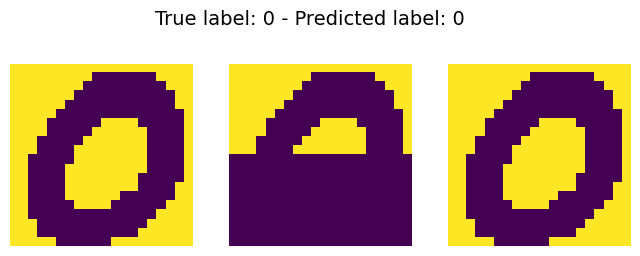

True label: 1, Predicted label: 2


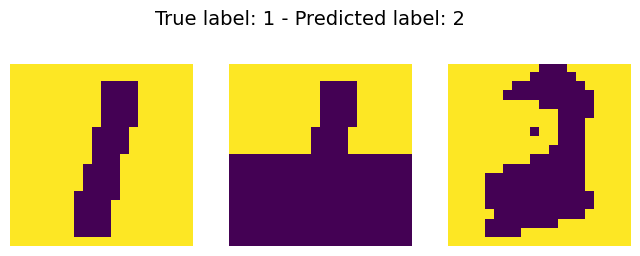

True label: 2, Predicted label: 2


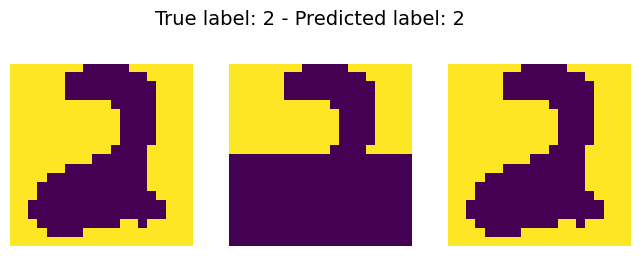

True label: 3, Predicted label: 8


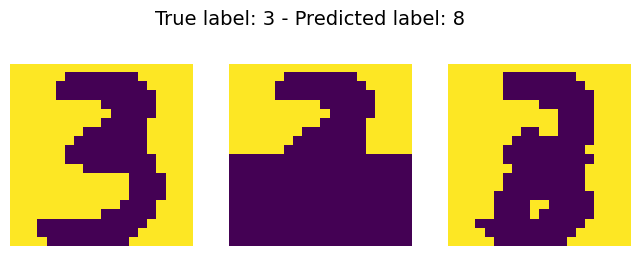

True label: 4, Predicted label: 4


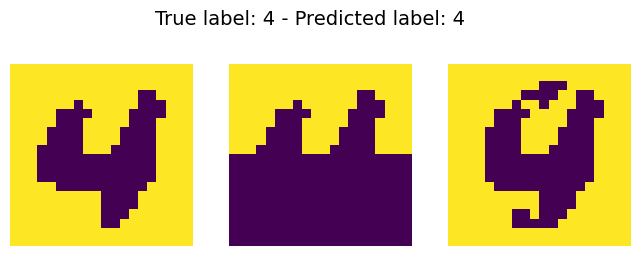

True label: 5, Predicted label: 5


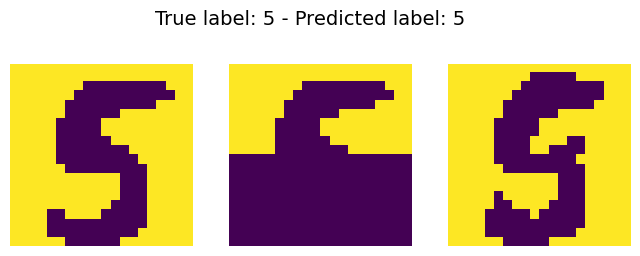

True label: 6, Predicted label: 6


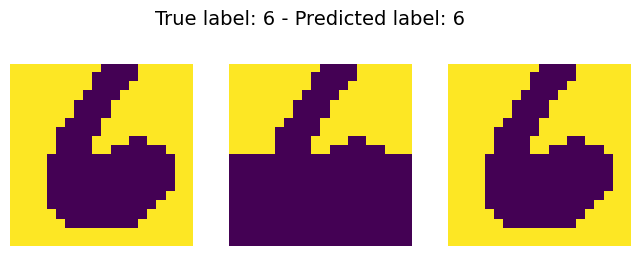

True label: 7, Predicted label: 7


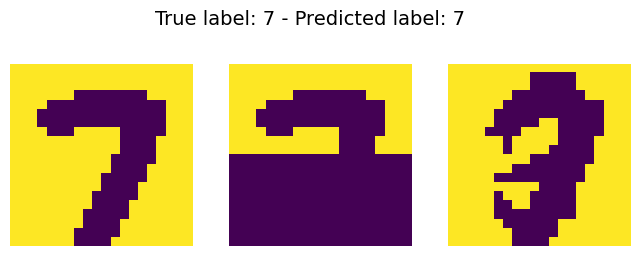

True label: 8, Predicted label: 8


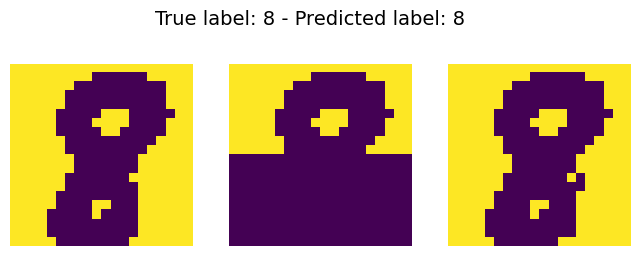

True label: 9, Predicted label: 9


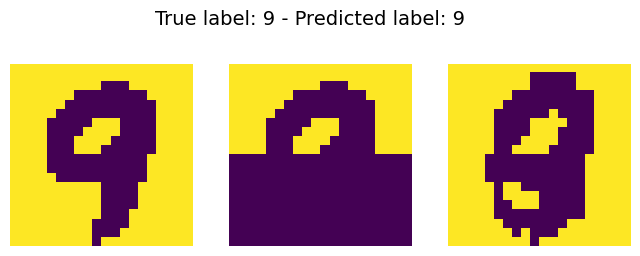

In [16]:
# Create the object
m_hopfield = modern_hopfield(pattern_lenght=784)

# Store the patterns
patterns = np.array(patterns)
m_hopfield.add_patterns(patterns)

for p, true_label in zip(patterns, labels):
    # Crea la versione corrotta del pattern
    cut = cut_image(p, "left")
    # Recupera il pattern utilizzando il modello Hopfield (1 epoca per esempio)
    recovered = m_hopfield.retrieve_pattern(cut, epochs=1)
    
    # Predici la label confrontando il pattern recuperato con i pattern memorizzati
    predicted_label = predict_label(recovered, patterns, labels)
    
    # Stampa le label
    print(f"True label: {true_label}, Predicted label: {predicted_label}")
    
    # Visualizza il pattern originale, quello corrotto e quello recuperato
    plt.figure(figsize=(8, 3))
    for i, img in enumerate([p, cut, recovered]):
        plt.subplot(1, 3, i+1)
        plt.imshow(img.reshape(20, 20))
        plt.axis('off')
    plt.suptitle(f"True label: {true_label} - Predicted label: {predicted_label}", fontsize=14)
    plt.show()

[-72234392, -103689752, -104070232, -107919512, -127910664, -129344120, -103469032, -129125864, -129290856, -159849240]


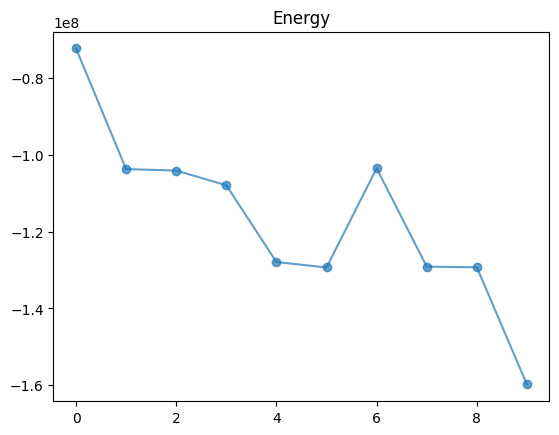

In [13]:
energy = []
for p in patterns:
    E = m_hopfield.energy(p)  
    energy.append(E)

print(energy)
plt.plot(np.arange(0, 10, 1), energy, marker="o", alpha=0.7)
plt.title("Energy")
plt.show()

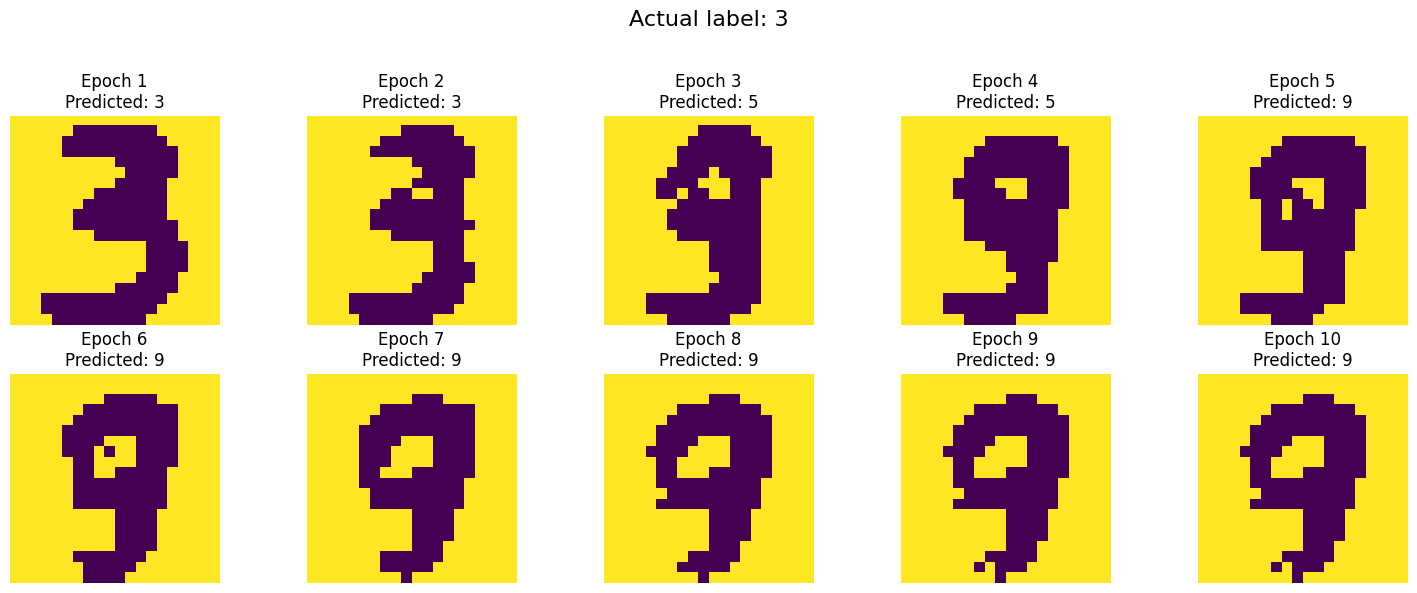

In [14]:
i = 3  # indice del pattern che vogliamo testare
original = patterns[i]          # pattern originale (1D)
actual_label = labels[i]        # label reale
corrupted = cut_image(original, "bottom")  # versione corrotta del pattern

# Creiamo una figura con 2 righe e 5 colonne (totale 10 subplot)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()  # per iterare più comodamente

for epoch in range(10):
    # Recupera il pattern per l'epoca corrente; se vuoi partire dal pattern corrotto, usa 'corrupted'
    retrieved = m_hopfield.retrieve_pattern(p=corrupted, epochs=epoch)
    predicted_label = predict_label(retrieved, patterns, labels)
    
    # Visualizza il pattern recuperato nell'asse corrispondente
    axes[epoch].imshow(retrieved.reshape(20, 20))
    axes[epoch].set_title(f"Epoch {epoch+1}\nPredicted: {predicted_label}")
    axes[epoch].axis("off")

# Aggiungiamo un titolo complessivo alla figura con la label reale
plt.suptitle(f"Actual label: {actual_label}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
